In [110]:
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt
import numpy as np
import pickle
import string
import itertools

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Helper functions
#
## CONFUSION MATRIX ###

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## top10keywords from pipeline ##

def top10keys(pipe_model, classes):
    vectorizer = pipe_model.named_steps['vectorizer']
    clf = pipe_model.named_steps['clf']
    
    features_names = vectorizer.get_feature_names()
    features_names = np.asarray(features_names)
    
    print('Number of features: {} \n'.format(len(features_names)))
    
    try:
        if len(classes) > 2:
            for i, label in enumerate(classes):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print('%s: %s' % (label,', '.join(features_names[top10])))
        else:
            top10 = np.argsort(clf.coef_[0])[-10:] 
            print('Top 10 features found in %s:' % (classes[1]))
            print('%s' % (', '.join(features_names[top10])))
    except AttributeError:
        top10 = np.argsort(clf.feature_importances_)[-10:]
        print('Top 10 features found in %s:' % (classes[1]))
        print('%s' % (', '.join(features_names[top10])))
    
#     try:
#         for i, label in enumerate(classes):
#             top10 = np.argsort(clf.coef_[i])[-10:]
#             #print('Top 10 features \n')
#             print('%s: %s' % (label,', '.join(features_names[top10])))
#     except IndexError:
#         try:
#             top10 = np.argsort(clf.coef_[0])[-10:]
#             print('Top 10 features found in %s:' % (classes[1]))
#             print('%s' % (', '.join(features_names[top10])))
#         except AttributeError:
#             top10 = np.argsort(clf.feature_importances_)[-10:]
#             #print('Top 10 features found in %s:' % (classes[1]))
#             #print('%s' % (', '.join(features_names[top10])))
        
## predict and print all the stuff ##

def predict_and_win(classes_names):
    y_pred = pipe.predict(X_test)
    print('Classification Report: \n')
    print(metrics.classification_report(y_test, y_pred))
    print('='*60)
    print('Accuracy: {}'.format(metrics.accuracy_score(y_test,y_pred)))
    print('='*60)
    plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), classes=classes_names, title='Confusion matrix')


# Project 4: NLP, NLP, NLP

We will be doing all classification models and attempt to kill two ~~birds~~ questions with one ~~stone~~ classification model - which is Section 1 and the bonus section. However, I would require the answers to Section 2 before I am able to do Section 1 So, I won't be going through the project in the same order as the README file. Sorry...

## Bringing in my tables from SQL

In [3]:
connection = sqlite3.connect('job_scraped.db.sqlite')

In [4]:
sql_query = '''
SELECT *
FROM jobs
'''

In [5]:
df = pd.read_sql(sql_query, con=connection)

In [6]:
df.head()

,description,id,title
0,Dubbed “The Most Innovative Streaming Video Se...,2abc0718a6987824,Data Analyst
1,Title: Data Analyst\n\nRole:\n\nReporting to t...,c95dd846041ca1c5,Data Analyst
2,What is the job ?\n\n\nThe role will involve m...,59df81c8a00dc826,Junior Data Analyst
3,Data Analyst - (180000E0)\nDescription\n\nUnde...,6d9971d09cb788a6,Data Analyst
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst


In [7]:
# Check for duplicates
df['id'].duplicated(keep='first').sum()

0

In [8]:
# Check for data entry jobs
df[df['title'].str.contains('Data Entry')]

,description,id,title


In [9]:
# Check for Internships
df[df['title'].str.contains('Internship')]

,description,id,title
17,"Expedia\n\nIf you are seeking a collaborative,...",b4360fcd5896614c,Internship – Singapore – Data Growth Analyst I...
19,In your new role you will:\nAssist analytics t...,7ea2500e814e660b,Internship - Data Analyst
169,Job Summary\n\nJob Title: Summer Internship 20...,a4be9d6531a5fd98,Summer Internship 2018
258,About Us:\nGE is the world's Digital Industria...,bf54a0408db5e412,Internship -Business Analyst- Healthcare (Jul ...
478,About Us:\nGE is the world's Digital Industria...,14533e4fd58270cf,Internship - Service Operations
497,About Us:\nGE is the world’s Digital Industria...,055cb0d9d8aa982c,GE Aviation Internship
521,In your role you will:\nBe involved in key pro...,207475703e8d5f08,Internship - Test Automation
534,In your new role you will\nBe involved in lots...,67081fd9c763ba0f,Internship - Product Test Engineering (Automat...
902,About the Role\n\n\nInformation Technology at ...,86b371ee515b345c,Artificial Intelligent Bot Engineer - Internship
1101,In your new role you will:\nStudy and assess c...,93c36bce0027be71,Internship - R&D Big Data Analysis using AI/ML


Hurray! No duplicates! and no data entry jobs. There are some internships, but let's leave them in and see what happens.

## 1) Data Scientists versus others
What components of a job posting distinguish data scientists from other data jobs?

### Data Scientist vs Data Analyst vs Data Engineer

In [10]:
# Extracting all jobs with "Data Science" in the title

only_ds = df[df['title'].isin(['Data Scientist','Junior Data Scientist','Senior Data Scientist'])].copy()
only_ds['label'] = 'DS'

In [11]:
only_da = df[df['title'].isin(['Data Analyst','Junior Data Analyst','Senior Data Analyst'])].copy()
only_da['label'] = 'DA'

In [12]:
only_de = df[df['title'].isin(['Data Engineer','Junior Data Engineer','Senior Data Engineer'])].copy()
only_de['label'] = 'DE'

In [13]:
ds_vs_others = pd.concat([only_ds,only_da,only_de], ignore_index=True)

In [14]:
ds_vs_others.head()

,description,id,title,label
0,PURPOSE OF THE ROLE\nThis role of a data scien...,21a0e80107ccbbc3,Data Scientist,DS
1,Work cross-functionally with business managers...,95a6064e4ea39071,Data Scientist,DS
2,Serve as primary source of data insights suppo...,dc9137eaa6d7040a,Data Scientist,DS
3,"Big data, artificial intelligence and advanced...",8401de1b34480359,Data Scientist,DS
4,As the innovation leader in the logistics indu...,eb0952cd8bad461b,Data Scientist,DS


In [15]:
ds_vs_others['label'].value_counts()

DS    33
DE    25
DA    21
Name: label, dtype: int64

In [16]:
print('Baseline: {}'.format(1.0-(float(33)/float(33+25+21))))

Baseline: 0.582278481013


WOOT! I have a balanced dataset :) albeit small.... but let's see if we can infer anything from it using NLP.

### Simple cleaning, no stemming or lemmitization or removal of stop words because it is so small (rows = 60+).

In [17]:
# Removing punctuation, numbers and lowercase all
ds_vs_others['clean'] = ds_vs_others['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [18]:
ds_vs_others.head()

,description,id,title,label,clean
0,PURPOSE OF THE ROLE\nThis role of a data scien...,21a0e80107ccbbc3,Data Scientist,DS,purpose of the role this role of a data scient...
1,Work cross-functionally with business managers...,95a6064e4ea39071,Data Scientist,DS,work cross functionally with business managers...
2,Serve as primary source of data insights suppo...,dc9137eaa6d7040a,Data Scientist,DS,serve as primary source of data insights suppo...
3,"Big data, artificial intelligence and advanced...",8401de1b34480359,Data Scientist,DS,big data artificial intelligence and advanced...
4,As the innovation leader in the logistics indu...,eb0952cd8bad461b,Data Scientist,DS,as the innovation leader in the logistics indu...


In [19]:
X = ds_vs_others['clean']
y = ds_vs_others['label']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', LogisticRegressionCV(cv=3, random_state=42))
])

model = pipe.fit(X_train, y_train)

In [22]:
top10keys(model, classes=['DA', 'DE', 'DS'])

Number of features: 2696 

DA: analysis, skills, strong, and, reports, business, clients, requirements, reporting, analyst
DE: skill, is, pipelines, number, infrastructure, building, you, of, data, engineer
DS: problems, scientist, in, business, research, analytics, science, models, machine, learning


Classification Report: 

             precision    recall  f1-score   support

         DA       0.67      0.67      0.67         6
         DE       1.00      0.57      0.73         7
         DS       0.71      0.91      0.80        11

avg / total       0.79      0.75      0.75        24

Accuracy: 0.75
Confusion matrix, without normalization
[[ 4  0  2]
 [ 1  4  2]
 [ 1  0 10]]


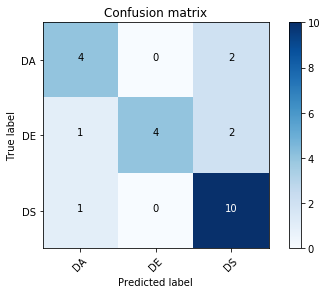

In [23]:
predict_and_win(['DA', 'DE', 'DS'])

Yup, as expected. Because DA's top 10 keywords had company names in the mix which of course will throw it off course quite fast and easily.

In [24]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', SGDClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

top10keys(model, classes=['DA', 'DE', 'DS'])

Number of features: 11268 

DA: planning, microsoft, reports, audit, clients, sales, customer, reporting, data analyst, analyst
DE: end, data, data warehousing, infrastructure, skill, warehousing, aws, pipelines, data engineer, engineer
DS: stakeholders, data scientist, scientist, data analytics, learning, machine learning, machine, models, research, analytics


/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Classification Report: 

             precision    recall  f1-score   support

         DA       0.60      0.50      0.55         6
         DE       1.00      0.71      0.83         7
         DS       0.71      0.91      0.80        11

avg / total       0.77      0.75      0.75        24

Accuracy: 0.75
Confusion matrix, without normalization
[[ 3  0  3]
 [ 1  5  1]
 [ 1  0 10]]


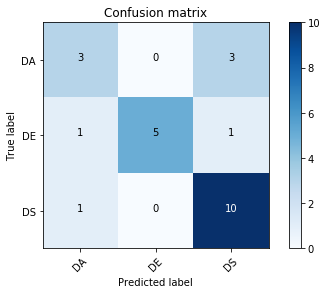

In [25]:
predict_and_win(['DA', 'DE', 'DS'])

At this point, I went back and scraped for company names. I just needed enough to add as stop words.

In [26]:
# Load in the pickled list of company names
with open('company_names.p','rb') as f:
    company_names = pickle.load(f)

In [27]:
# Remove duplicates
company_names = list(set(company_names))

# Turn into dataframe for easy removal of punctuation and lowercasing
company_df = pd.DataFrame({'companies': company_names})

In [28]:
company_names = company_df['companies'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower().split()).tolist()
company_names = [y for x in company_names for y in x]

In [29]:
# Remove duplicates
company_names = list(set(company_names))

# Add 'jll' because it is a real estate company and microsoft because .... microsoft
company_names.extend(['jll','microsoft'])

In [30]:
# Add to the stopwords list
stop_words1 = ENGLISH_STOP_WORDS.union(company_names)

In [31]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words1, ngram_range=(1,2))),
    ('clf', SGDClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

top10keys(model, classes=['DA', 'DE', 'DS'])

Number of features: 10478 

DA: report, great work, ability, audit, planning, reporting, clients, sales, data analyst, analyst
DE: infrastructure, engineering, end, data warehousing, skill, aws, warehousing, pipelines, data engineer, engineer
DS: fraud, algorithms, machine learning, stakeholders, learning, data scientist, scientist, machine, models, research


Classification Report: 

             precision    recall  f1-score   support

         DA       0.80      0.67      0.73         6
         DE       1.00      0.86      0.92         7
         DS       0.77      0.91      0.83        11

avg / total       0.84      0.83      0.83        24

Accuracy: 0.833333333333
Confusion matrix, without normalization
[[ 4  0  2]
 [ 0  6  1]
 [ 1  0 10]]


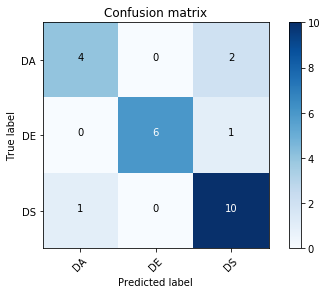

In [32]:
predict_and_win(['DA', 'DE', 'DS'])

In [33]:
# Let's do this with the ensemble method of the boosting family: GradientBoostingClassifier which is quite similar to the SGDClassifier 
# in that they both utilize Gradient Descent

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words1, ngram_range=(1,2))),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

Classification Report: 

             precision    recall  f1-score   support

         DA       1.00      0.67      0.80         6
         DE       1.00      1.00      1.00         7
         DS       0.85      1.00      0.92        11

avg / total       0.93      0.92      0.91        24

Accuracy: 0.916666666667
Confusion matrix, without normalization
[[ 4  0  2]
 [ 0  7  0]
 [ 0  0 11]]


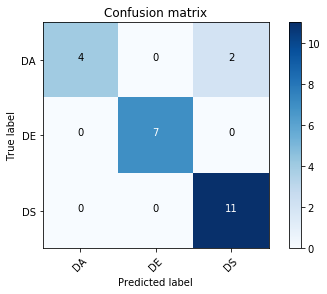

In [34]:
predict_and_win(['DA', 'DE', 'DS'])

### Conclusion

Removing company names (as much as possible) resulted in more mis-classifications of Data Analysts as Data Scientist, but less for the other way round. Without company names in the mix, the job description are close enough that there's a higher chance of mis-classification. This leads me to the following:

1. Some companies posts Data Scientists job titles but the job descriptions reads closer to a Data Analyst title.
2. Because I added Junior Data Scientists in the Data Scientist pool, perhaps that caused the mix of job description as Jr. Data Scientists tend to be Data Analysts.
3. Data Analyst did have the lowerest number of samples, so not too surprised that it wasn't able to catch them all. 
4. One can argue that Data Analysts and Data Scientist are in the same cluster as each other, as compared to Data Engineers. Throughout all iterations, DEs were well classified and accurately so, with one wrong one (each)

**Lesson:** It is possible to derive some insights from a small dataset, it is just very important to clean the data as much as possible and be mindful of the top10 words in both categories (don't remove too much and/or don't remove too little).

**Choosing models:** A combination of simple models, or a simple model is better than a single complicated model. LogisticRegression did quite well on its own, unoptimized. GradientBoostingClassifier, which is a combination of weaker models also did very well. SGDClassifier needed a lot of work (added more stop words) to even meet LogisticRegression's first attempt.



## 2) What features are important for distinguishing junior vs. senior positions?

Salary numbers: https://www.techinasia.com/data-scientist-salaries-singapore-revealed and https://www.payscale.com/ 

In [35]:
only_jr = df[df['title'].str.contains('Junior|Jr|Associate|Assoc|Executive|Exec|Entry')].copy()
only_jr['label'] = 'Jr'

In [36]:
only_sr = df[df['title'].str.contains('Senior|Sr')].copy()
only_sr['label'] = 'Sr'

In [37]:
jr_vs_sr = pd.concat([only_jr,only_sr], ignore_index=True)

In [38]:
jr_vs_sr['label'].value_counts()

Sr    196
Jr    103
Name: label, dtype: int64

In [39]:
print('Baseline: {}'.format(float(196)/float(103+196)))

Baseline: 0.655518394649


In [40]:
jr_vs_sr.head()

,description,id,title,label
0,What is the job ?\n\n\nThe role will involve m...,59df81c8a00dc826,Junior Data Analyst,Jr
1,About the Business Analyst position\n\nWe are ...,97326f6a06a4d7dc,Business Analyst/Junior PM,Jr
2,Contribute to the Revenue Optimization departm...,b3410677f90d5db2,"Associate Analyst/Analyst, Analytics",Jr
3,BlackRock helps investors build better financi...,d40e45e6c5c014ad,"Data Implementation, Associate",Jr
4,The Company\nWillis Towers Watson is a leading...,ea2518a4ebd725fd,"Analyst - Executive Compensation, Singapore",Jr


In [41]:
jr_vs_sr['clean'] = jr_vs_sr['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [42]:
X = jr_vs_sr['clean']
y = jr_vs_sr['label']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegressionCV(cv=3, random_state=42, class_weight='balanced'))
])

model = pipe.fit(X_train, y_train)

In [45]:
top10keys(model, ['Junior','Senior'])

Number of features: 5862 

Top 10 features found in Senior:
technical, lead, architecture, product, oracle, science, project, senior, experience, business


Classification Report: 

             precision    recall  f1-score   support

         Jr       0.73      0.54      0.62        35
         Sr       0.75      0.87      0.81        55

avg / total       0.74      0.74      0.74        90

Accuracy: 0.744444444444
Confusion matrix, without normalization
[[19 16]
 [ 7 48]]


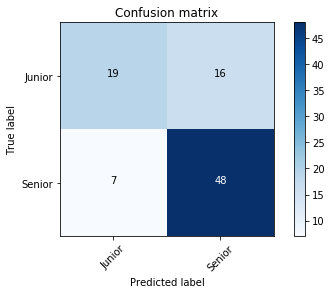

In [46]:
predict_and_win(['Junior','Senior'])

In [47]:
# Add 'responsibilities','requirements','relevant','years' and others to stop words
stop_words2 = stop_words1.union(['oracle','axa','edb','responsibilities','requirements','relevant','years','science','experience','advantage','phd','senior'])

In [48]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2, ngram_range=(2,2), max_df=0.8)),
    ('clf', SGDClassifier(random_state=42, class_weight='balanced'))
])

model = pipe.fit(X_train, y_train)

In [49]:
top10keys(model, ['Junior','Senior'])

Number of features: 32562 

Top 10 features found in Senior:
possess strong, roles utilizing, business analyst, sql server, degree computer, business problems, business process, ms sql, working knowledge, best practices


Classification Report: 

             precision    recall  f1-score   support

         Jr       0.63      0.63      0.63        35
         Sr       0.76      0.76      0.76        55

avg / total       0.71      0.71      0.71        90

Accuracy: 0.711111111111
Confusion matrix, without normalization
[[22 13]
 [13 42]]


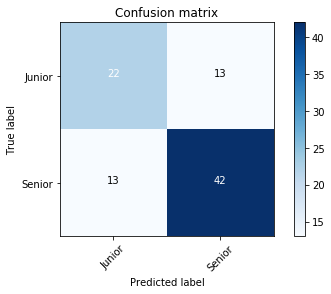

In [50]:
predict_and_win(['Junior','Senior'])

In [51]:
# Ensemble method here:

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2, ngram_range=(1,2), max_df=0.6)),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

Classification Report: 

             precision    recall  f1-score   support

         Jr       0.67      0.63      0.65        35
         Sr       0.77      0.80      0.79        55

avg / total       0.73      0.73      0.73        90

Accuracy: 0.733333333333
Confusion matrix, without normalization
[[22 13]
 [11 44]]


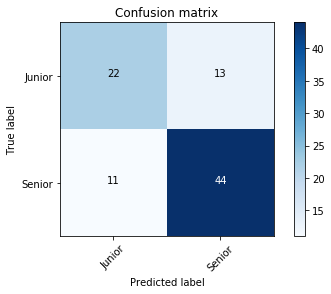

In [52]:
predict_and_win(['Junior','Senior'])

### Conclusion

One can argue that most of today's Junior roles in Data Science share a lot of key terms with Senior roles (models overall did better once 'PhD' was removed). `max_df` had to be set at a precise 0.60 in order to produce a better predictions. This means that it removed all terms that appeared more than 60% in all documents. There are two reasons to this:
1. Job adverts tend to sound kinda the same anyway.
2. A Senior role can be defined as someone with a Junior role AND 40% more. Pinpoining the terms down to these few, would need a lot more tuning.

I am quite happy with 0.73 accuracy score here as I don't want it to overfit on this and it is an imbalanced dataset to start with. LogisticRegression didn't do so well this time, but could be due to the imbalanced classes.


### For Boss

Junior and Senior 'accuracy' is not really what the boss wants. Since he/she would like to inform a candidate that they would receive a lower salary that they would, in reality, get. With this, this means that we would need to find a model that would optimise for lower False Negatives (lower Senior predictions).

In [62]:
jr_vs_sr.head()

,description,id,title,label,clean
0,What is the job ?\n\n\nThe role will involve m...,59df81c8a00dc826,Junior Data Analyst,Jr,what is the job the role will involve main...
1,About the Business Analyst position\n\nWe are ...,97326f6a06a4d7dc,Business Analyst/Junior PM,Jr,about the business analyst position we are lo...
2,Contribute to the Revenue Optimization departm...,b3410677f90d5db2,"Associate Analyst/Analyst, Analytics",Jr,contribute to the revenue optimization departm...
3,BlackRock helps investors build better financi...,d40e45e6c5c014ad,"Data Implementation, Associate",Jr,blackrock helps investors build better financi...
4,The Company\nWillis Towers Watson is a leading...,ea2518a4ebd725fd,"Analyst - Executive Compensation, Singapore",Jr,the company willis towers watson is a leading ...


In [64]:
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative
# So if it is Junior role, never ever label it as Sr

jr_vs_sr['label'] = jr_vs_sr['label'].map({'Jr': 0, 'Sr': 1})

In [67]:
X = jr_vs_sr['clean']
y = jr_vs_sr['label']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [115]:
# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2)),
    ('clf', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vectorizer__max_df': (0.5, 0.75, 1.0),
    #'vectorizer__max_features': (None, 5000, 10000, 50000),
    'vectorizer__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'vectorizer__use_idf': (True, False),
    #'vectorizer__norm': ('l1', 'l2'),
    'clf__C': ([0.1,1.0,5.0]),
    'clf__penalty': ('l2', 'l1')
}

In [116]:
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=1, cv=3, scoring='precision')

    print("Performing grid search...")
    
    grid_search.fit(X_train, y_train)
    
    print("Best score: %0.3f \n" % grid_search.best_score_)
    
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)

Best score: 0.744 

Best parameters set:
	clf__C: 5.0
	clf__penalty: 'l2'
	vectorizer__max_df: 0.5
	vectorizer__ngram_range: (1, 1)


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    9.1s finished


Classification Report: 

             precision    recall  f1-score   support

          0       0.68      0.53      0.59        51
          1       0.78      0.87      0.82        99

avg / total       0.75      0.75      0.74       150

Accuracy: 0.753333333333
Confusion matrix, without normalization
[[27 24]
 [13 86]]


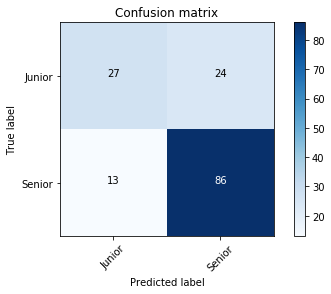

In [117]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2, ngram_range=(1, 1), max_df=1.0)),
    ('clf', LogisticRegression(random_state=42, class_weight='balanced', C=5.0, penalty='l1'))
])

model = pipe.fit(X_train, y_train)

predict_and_win(['Junior','Senior'])

# 3) Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

In [ ]:
df.head()

In [ ]:
df[df['description'].str.contains('industry')].count()

I am not going to kill myself and the model trying to sieve through finance vs banking. So I will choose two opposite industries that also _happens_ to have a balanced class count: Manufacturing and Finance.

In [ ]:
only_fin = df[df['description'].str.contains('finance')].copy()
only_fin['label'] = 'Finance'

In [ ]:
only_mfg = df[df['description'].str.contains('manufacturing')].copy()
only_mfg['label'] = 'Manufacturing'

In [ ]:
industry = pd.concat([only_fin,only_mfg], ignore_index=True)

# Dropping ID because we don't need it anymore, but we want Title later :D
industry.drop(columns=['id'], inplace=True)

In [ ]:
industry.head()

In [ ]:
industry['label'].value_counts()

In [ ]:
industry['clean'] = industry['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [ ]:
X = industry['clean']
y = industry['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

In [ ]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegressionCV(cv=3, random_state=42))
])

model = pipe.fit(X_train, y_train)

In [ ]:
top10keys(model, ['Finance','Manufacturing'])

In [ ]:
predict_and_win(['Finance','Manufacturing'])

I fear something might be amiss. 

In [ ]:
# Add 'manufacturing' and 'finance' to stop words
stop_words3 = stop_words1.union(['manufacturing','finance'])

In [ ]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words3)),
    ('clf', LogisticRegressionCV(cv=3, random_state=42))
])

model = pipe.fit(X_train, y_train)

In [ ]:
top10keys(model, ['Finance','Manufacturing'])

In [ ]:
predict_and_win(['Finance','Manufacturing'])

In [ ]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words3, ngram_range=(1,4))),
    ('clf', SGDClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

In [ ]:
top10keys(model, ['Finance','Manufacturing'])

In [ ]:
predict_and_win(['Finance','Manufacturing'])

In [ ]:
# Let's see if our GradientBoostingClassifier can make it even better

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words3, ngram_range=(1,4))),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

In [ ]:
top10keys(model, ['Finance','Manufacturing'])

In [ ]:
predict_and_win(['Finance','Manufacturing'])

### Conclusion

KISS wins the day. Keep it Simple, Stupid. LogisticRegression performed the best.

# 4) Salary Prediction

My original dataset did not have any salary column. And it also contained search results that are not entirely related. I plan to solve it this way:
1. Predict if the role is either DS/DA, DE or DArch, or others. 
2. Predict if the role is either Jr. or Sr.
3. Sort accordingly.

I wonder if I can do some clustering...

https://stackoverflow.com/questions/8897593/similarity-between-two-text-documents and http://brandonrose.org/clustering

In [ ]:
ds_vs_others.head()

In [ ]:
jr_vs_sr.head()

In [ ]:
ds_vs_others.info()

In [ ]:
jr_vs_sr.info()

In total I have 79 data points to train my first randomforest classifier. I then have 299 to classify senior vs junior. Bearing in mind that there might be overlaps in these two datasets even, I will assume there aren't any, and this means that I will be training on 79+299 = 378 data points. Which leaves me about 1000 rows to test on. 

In [ ]:
# Remove all those ids not in either jr_vs_sr or ds_vs_others tables

Xsalary_test = df[~df['id'].isin(ds_vs_others['id'])].copy()
Xsalary_test = df[~df['id'].isin(jr_vs_sr['id'])].copy()

In [ ]:
Xsalary_test.info()

In [ ]:
Xsalary_test.head()

In [ ]:
Xsalary_test['clean'] = Xsalary_test['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [ ]:
Xsalary_test.head()

In [ ]:
X_ds = ds_vs_others['clean']
y_ds = ds_vs_others['label']

X_sr = jr_vs_sr['clean']
y_sr = jr_vs_sr['label']

In [ ]:
# Bring in the best model for DS vs others.
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words1, ngram_range=(1,2))),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_ds, y_ds)

In [ ]:
ds_pred = model.predict(Xsalary_test['clean'])
Xsalary_test['is_DS'] = ds_pred

In [ ]:
Xsalary_test.head()

In [ ]:
# Best model for Jr vs Sr

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2, ngram_range=(1,2), max_df=0.6)),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_sr, y_sr)

In [ ]:
sr_pred = model.predict(Xsalary_test['clean'])
Xsalary_test['is_Sr'] = sr_pred

In [ ]:
Xsalary_test.head()

In [ ]:
Xsalary_test['is_DS'].value_counts()

In [ ]:
Xsalary_test['is_Sr'].value_counts()

In [ ]:
Xsalary_test[(Xsalary_test['is_DS']=='DE')]['is_Sr'].value_counts()

In [ ]:
m1 = Xsalary_test['is_DS'] == 'DS'
m2 = Xsalary_test['is_DS'] == 'DA'
m3 = Xsalary_test['is_DS'] == 'DE'

m4 = Xsalary_test['is_Sr'] == 'Sr'
m5 = Xsalary_test['is_Sr'] == 'Jr'

In [ ]:
Xsalary_test['salary'] = 0

In [ ]:
Xsalary_test.loc[m1 & m4, 'salary'] = 136783 # Senior DS roles
Xsalary_test.loc[m1 & m5, 'salary'] = 59480 # Junior DS roles

Xsalary_test.loc[m2 & m4, 'salary'] = 59480 # Senior DA roles
Xsalary_test.loc[m2 & m5, 'salary'] = 77998 # Junior DA roles

Xsalary_test.loc[m3 & m4, 'salary'] = 100000 # Senior DE roles
Xsalary_test.loc[m3 & m5, 'salary'] = 60606 # Junior DE roles

In [ ]:
Xsalary_test.head()

In [ ]:
# Check out the smallest group: Junior DEs

Xsalary_test[(m3 & m5)]

Let's check out a potential mis-classification...

In [ ]:
print(Xsalary_test.loc[462, 'description'])

In [ ]:
Xsalary_test[(Xsalary_test['is_DS']=='DS')]['is_Sr'].value_counts()

In [ ]:
Xsalary_test[(m1 & m5)].sample(5)

In [ ]:
print(Xsalary_test.loc[392, 'description'])

In [ ]:
# I know there are internships in the titles. Let's look at those...

Xsalary_test[Xsalary_test['description'].str.contains('internship')].sample(5)

In [ ]:
print(Xsalary_test.loc[541, 'description'])

HAHAHAHAHA.....

Another one...

In [ ]:
print(Xsalary_test.loc[902, 'description'])

### LOL